
<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/Kagandi/ResNet-PyTorch/blob/main/cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Cifar-10 Training using ResNet

In [2]:
!git clone https://github.com/Kagandi/ResNet-PyTorch.git

Cloning into 'ResNet-PyTorch'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 41 (delta 17), reused 31 (delta 11), pack-reused 0
Receiving objects: 100% (41/41), 44.72 KiB | 5.59 MiB/s, done.
Resolving deltas: 100% (17/17), done.


In [2]:
%cd ResNet-PyTorch

/content/ResNet-PyTorch


In [3]:
from resnet_pytorch.data import CIFAR10Dataset
from resnet_pytorch import ResNet, ResidualBlock
from resnet_pytorch.models import resnet18
from resnet_pytorch.augmentaions import Flip, Rotate, Mirror, Contrast, Brightness
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from pathlib import Path
import torch.optim as optim
from tqdm.notebook import tqdm
import numpy as np
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
import time
import numpy as np
from resnet_pytorch.utils import imshow, EarlyStopping, show_predictions, denormalize
from resnet_pytorch import ResNet, ResidualBlock, ResNet9

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mean=[0.4914, 0.4822, 0.4465]
std=[0.2471, 0.2435, 0.2616]

## Dataloaders

In [55]:
preprocess = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
        Flip(),
        Rotate(min_degrees=0,max_degrees=10),
        Mirror(),
        # Contrast(),
        # Brightness(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2471, 0.2435, 0.2616]),
    ]
)


transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),
    ]
)
cifar10_dataset = CIFAR10Dataset(preprocess)
cifar10_dataloader = torch.utils.data.DataLoader(
    cifar10_dataset, batch_size=128, shuffle=True
)
# Stratified split into train test, and validation sets
train_indices, val_indices = train_test_split(
    list(range(len(cifar10_dataset))),
    test_size=0.2,
    stratify=cifar10_dataset.labels,
)
BS = 400
train_dataset = Subset(cifar10_dataset, train_indices)
val_dataset = Subset(cifar10_dataset, val_indices)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BS, shuffle=True
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=BS, shuffle=True)

## Parameter

In [7]:
EPOCHS = 30
LR = 0.01
wd = 1e-4
criterion = nn.CrossEntropyLoss()
resnet = None

In [ ]:
resnet =  ResNet9(3, 10).to(device)

optimizer = torch.optim.Adam(resnet.parameters(),LR,amsgrad=True
                        , weight_decay=wd)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=LR, steps_per_epoch=len(train_dataloader), epochs=EPOCHS
)
early_stoping = EarlyStopping(patience=7, verbose=False, path=f"models", delta=0.005)


## Training

In [18]:
for epoch in tqdm(range(EPOCHS)):
    total_loss = 0.0
    avg_loss = 0.0
    with tqdm(train_dataloader, unit="batch") as tepoch:
        for i, (inputs, labels) in enumerate(tepoch):
            inputs, labels = inputs.to(device), labels.to(device)
            tepoch.set_description(f"Epoch {epoch}")
            tepoch.set_postfix(
                train_loss=avg_loss,
                val_loss=np.nan,
                val_accuracy=np.nan,
            )

            optimizer.zero_grad()

            outputs = resnet(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            avg_loss = total_loss / (i + 1)

            if val_dataloader is not None and i == len(train_dataloader) - 1:
                with torch.no_grad():
                    val_loss = 0.0
                    val_score = 0.0
                    for i, (inputs, labels) in enumerate(val_dataloader):
                        inputs, labels = inputs.to(device), labels.to(device)
                        outputs = resnet(inputs)
                        loss = criterion(outputs, labels)
                        val_loss += loss.item()
                        val_score += (
                            (outputs.argmax(dim=1) == labels).float().mean().item()
                        )
                    val_loss /= len(val_dataloader)
                    val_score /= len(val_dataloader)
                    tepoch.set_postfix(
                        train_loss=avg_loss,
                        val_loss=val_loss,
                        val_accuracy=val_score,
                    )
                    time.sleep(0.5)
            scheduler.step()
        early_stoping(val_loss, resnet)
        if early_stoping.early_stop:
            print("Early stopping")
            break
resnet = torch.load(f"models/checkpoint.pt")


resnet.eval()

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?batch/s]

  0%|          | 0/100 [00:00<?, ?batch/s]

  0%|          | 0/100 [00:00<?, ?batch/s]

  0%|          | 0/100 [00:00<?, ?batch/s]

  0%|          | 0/100 [00:00<?, ?batch/s]

  0%|          | 0/100 [00:00<?, ?batch/s]

  0%|          | 0/100 [00:00<?, ?batch/s]

  0%|          | 0/100 [00:00<?, ?batch/s]

  0%|          | 0/100 [00:00<?, ?batch/s]

  0%|          | 0/100 [00:00<?, ?batch/s]

  0%|          | 0/100 [00:00<?, ?batch/s]

  0%|          | 0/100 [00:00<?, ?batch/s]

  0%|          | 0/100 [00:00<?, ?batch/s]

  0%|          | 0/100 [00:00<?, ?batch/s]

  0%|          | 0/100 [00:00<?, ?batch/s]

  0%|          | 0/100 [00:00<?, ?batch/s]

  0%|          | 0/100 [00:00<?, ?batch/s]

  0%|          | 0/100 [00:00<?, ?batch/s]

EarlyStopping counter: 1 out of 7


  0%|          | 0/100 [00:00<?, ?batch/s]

  0%|          | 0/100 [00:00<?, ?batch/s]

  0%|          | 0/100 [00:00<?, ?batch/s]

  0%|          | 0/100 [00:00<?, ?batch/s]

  0%|          | 0/100 [00:00<?, ?batch/s]

  0%|          | 0/100 [00:00<?, ?batch/s]

  0%|          | 0/100 [00:00<?, ?batch/s]

  0%|          | 0/100 [00:00<?, ?batch/s]

  0%|          | 0/100 [00:00<?, ?batch/s]

  0%|          | 0/100 [00:00<?, ?batch/s]

EarlyStopping counter: 1 out of 7


  0%|          | 0/100 [00:00<?, ?batch/s]

  0%|          | 0/100 [00:00<?, ?batch/s]

EarlyStopping counter: 1 out of 7


Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Test loss: 0.2940909829312049
Test accuracy: 0.9041533546325878


## Eval

Download previously trained weights:

In [26]:
!gdown 1axFi-VnQvofPdc3AduwWaTlj0TvxdqSm

Downloading...
From: https://drive.google.com/uc?id=1axFi-VnQvofPdc3AduwWaTlj0TvxdqSm
To: /content/ResNet-PyTorch/cifar10_resnet9.pt
100% 26.3M/26.3M [00:00<00:00, 44.4MB/s]


In [28]:
resnet = torch.load(f"cifar10_resnet9.pt")
resnet.eval()

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [33]:

# PATH = "./cifar_net.pth"
# torch.save(resnet.state_dict(), PATH)
criterion = nn.CrossEntropyLoss()

cifar10_dataset_test = CIFAR10Dataset(transform_test, train=False)
cifar10_dataloader_test = torch.utils.data.DataLoader(
    cifar10_dataset_test, batch_size=32, shuffle=False
)
predict = []
trues = []
with torch.no_grad():
    test_loss = 0.0
    test_score = 0.0
    for i, (inputs, labels) in enumerate(
        tqdm(cifar10_dataloader_test, unit="batch", desc="Test")
    ):
        inputs, labels = inputs.to(device), labels.to(device)
        trues.append(labels)
        outputs = resnet(inputs)
        predict.append(outputs.argmax(dim=1))
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        test_score += (outputs.argmax(dim=1) == labels).float().mean().item()
    test_loss /= len(cifar10_dataloader_test)
    test_score /= len(cifar10_dataloader_test)
    print(f"Test loss: {test_loss}")
    print(f"Test accuracy: {test_score}")

Test:   0%|          | 0/313 [00:00<?, ?batch/s]

Test loss: 0.2938948094208067
Test accuracy: 0.9042531948881789


In [20]:
!cp models/checkpoint.pt /content/drive/MyDrive/cifar10_resnet9.pt

In [42]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
predictions = torch.concat(predict)
y_test = torch.concat(trues)

predictions = predictions.cpu().numpy()
y_test = y_test.cpu().numpy()

In [31]:
acc = accuracy_score(y_test, predictions)
prec = precision_score(y_test, predictions, average="macro")
rec = recall_score(y_test, predictions, average="macro")
f1 = f1_score(y_test, predict, predictions="macro")
print(f"Accuracy: {acc}")
print(f"Precision: {prec}")
print(f"Recall: {rec}")
print(f"F1-score: {f1}")

Accuracy: 0.9043
Precision: 0.9042882698926527
Recall: 0.9042999999999999
F1-score: 0.9042293879407559


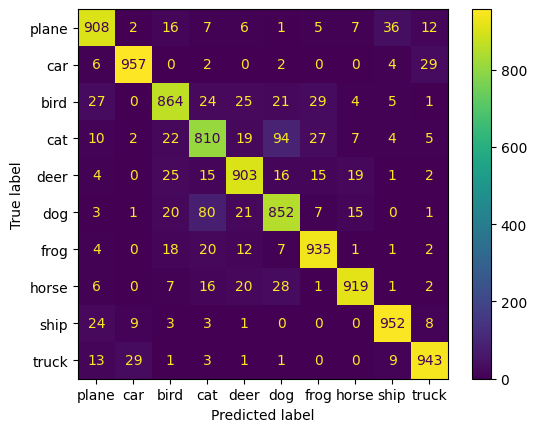

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
classes = cifar10_dataset_test.classes
cm = confusion_matrix([classes[y] for y in y_test], [classes[p] for p in predictions], labels=cifar10_dataset_test.classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=cifar10_dataset_test.classes)
disp.plot()
plt.show()

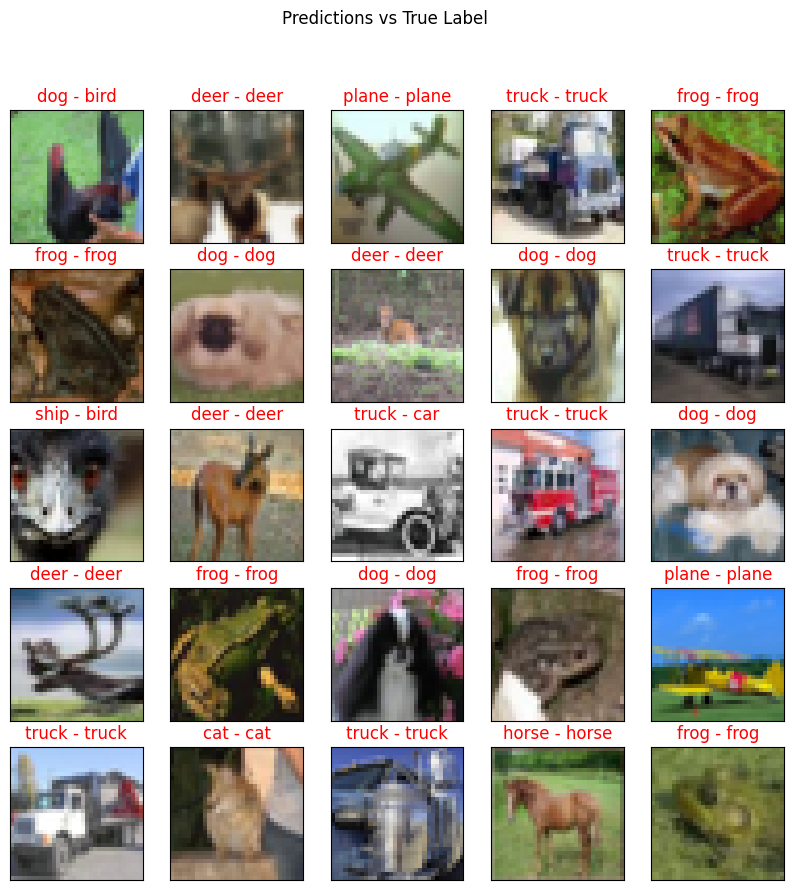

In [24]:
mean=[0.4914, 0.4822, 0.4465]
std=[0.2471, 0.2435, 0.2616]

show_predictions(predictions[25:], y_test[25:], [denormalize(cifar10_dataset_test[i+25][0],mean,std) for i in range(25)],  cifar10_dataset_test.classes)
